# Packages Used

* PennyLane (0.36.0)
    * Open-Source
    * Supports different backends.
    * Detailed doc (pennylane.ai)

* PyTorch (2.3.0)



---



# Import basic packages.

In [1]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.7 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 3.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.2 MB/s eta 0:00:00eta 0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.2 MB/s eta 0:00:00a 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 1.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 1.2 MB/s eta 0:00:00a 0:00:01


In [4]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 1.4 MB/s eta 0:00:00a 0:00:01


In [6]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 1.2 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 1.2 MB/s eta 0:00:0000:010m


In [1]:
import time

from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
from pandas import DataFrame

import warnings
import torchㅋ
import torch.nn as nn

import pennylane as qml
from pennylane import numpy as np

/Users/woojong/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# This is the QNN that we will use here.

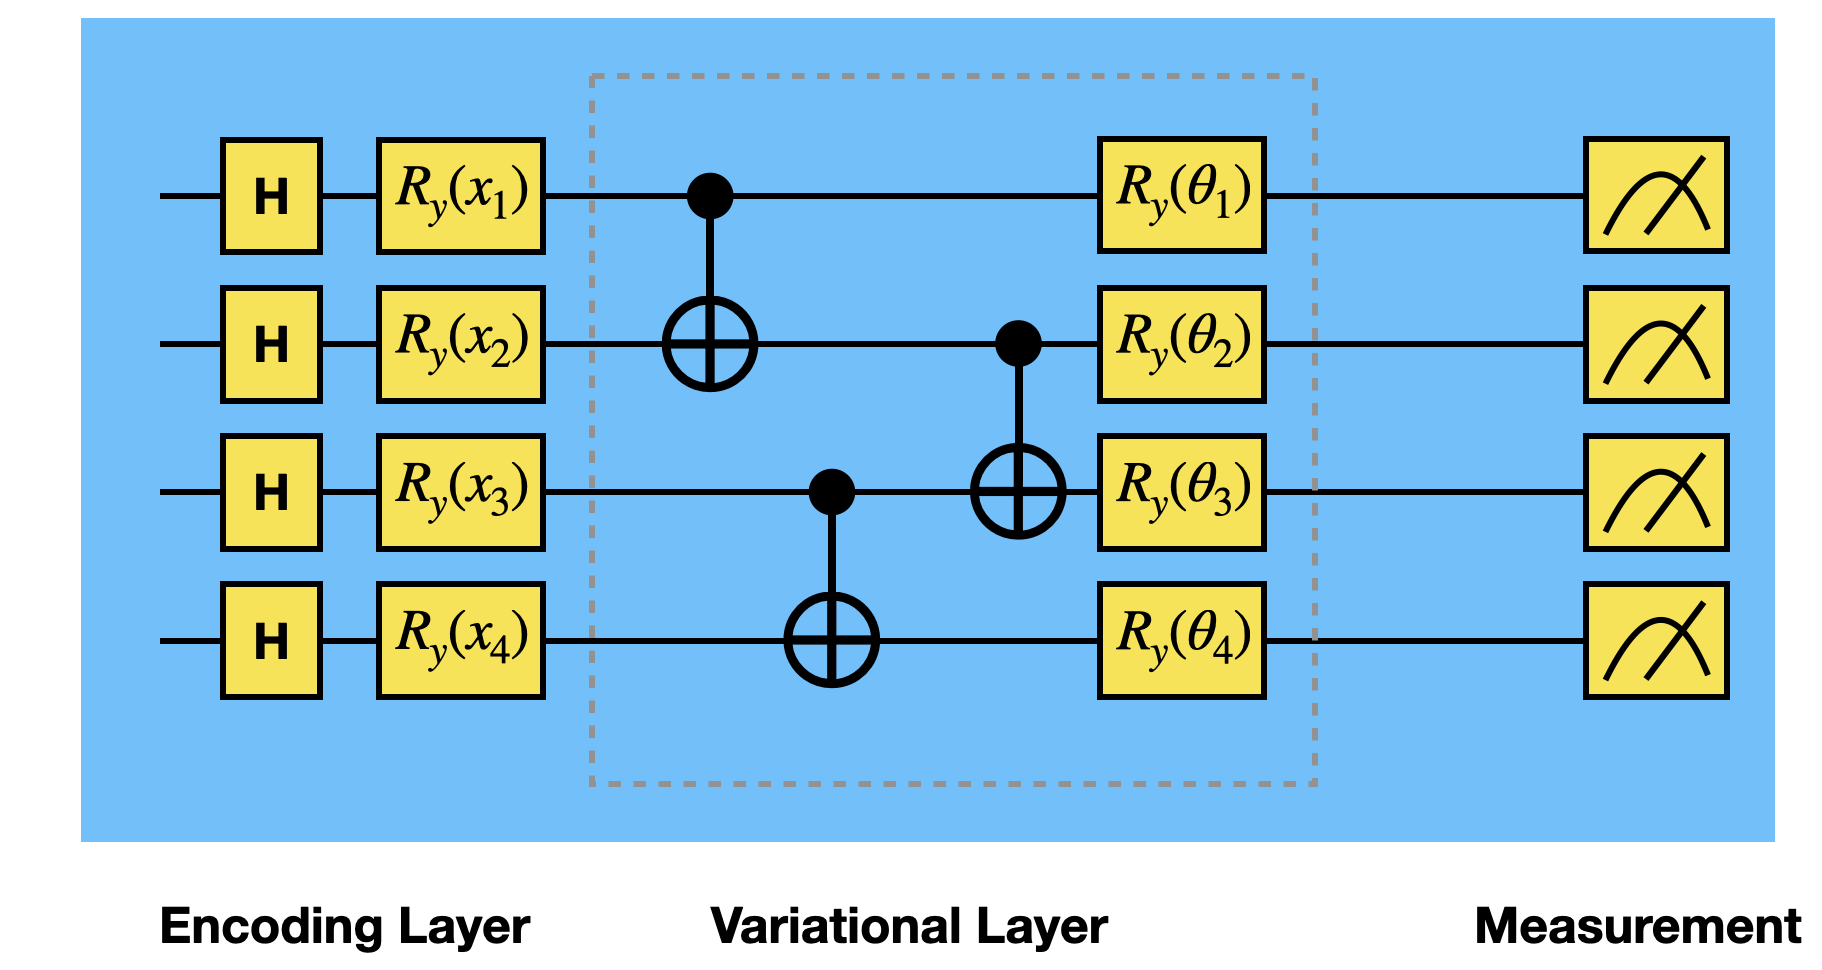

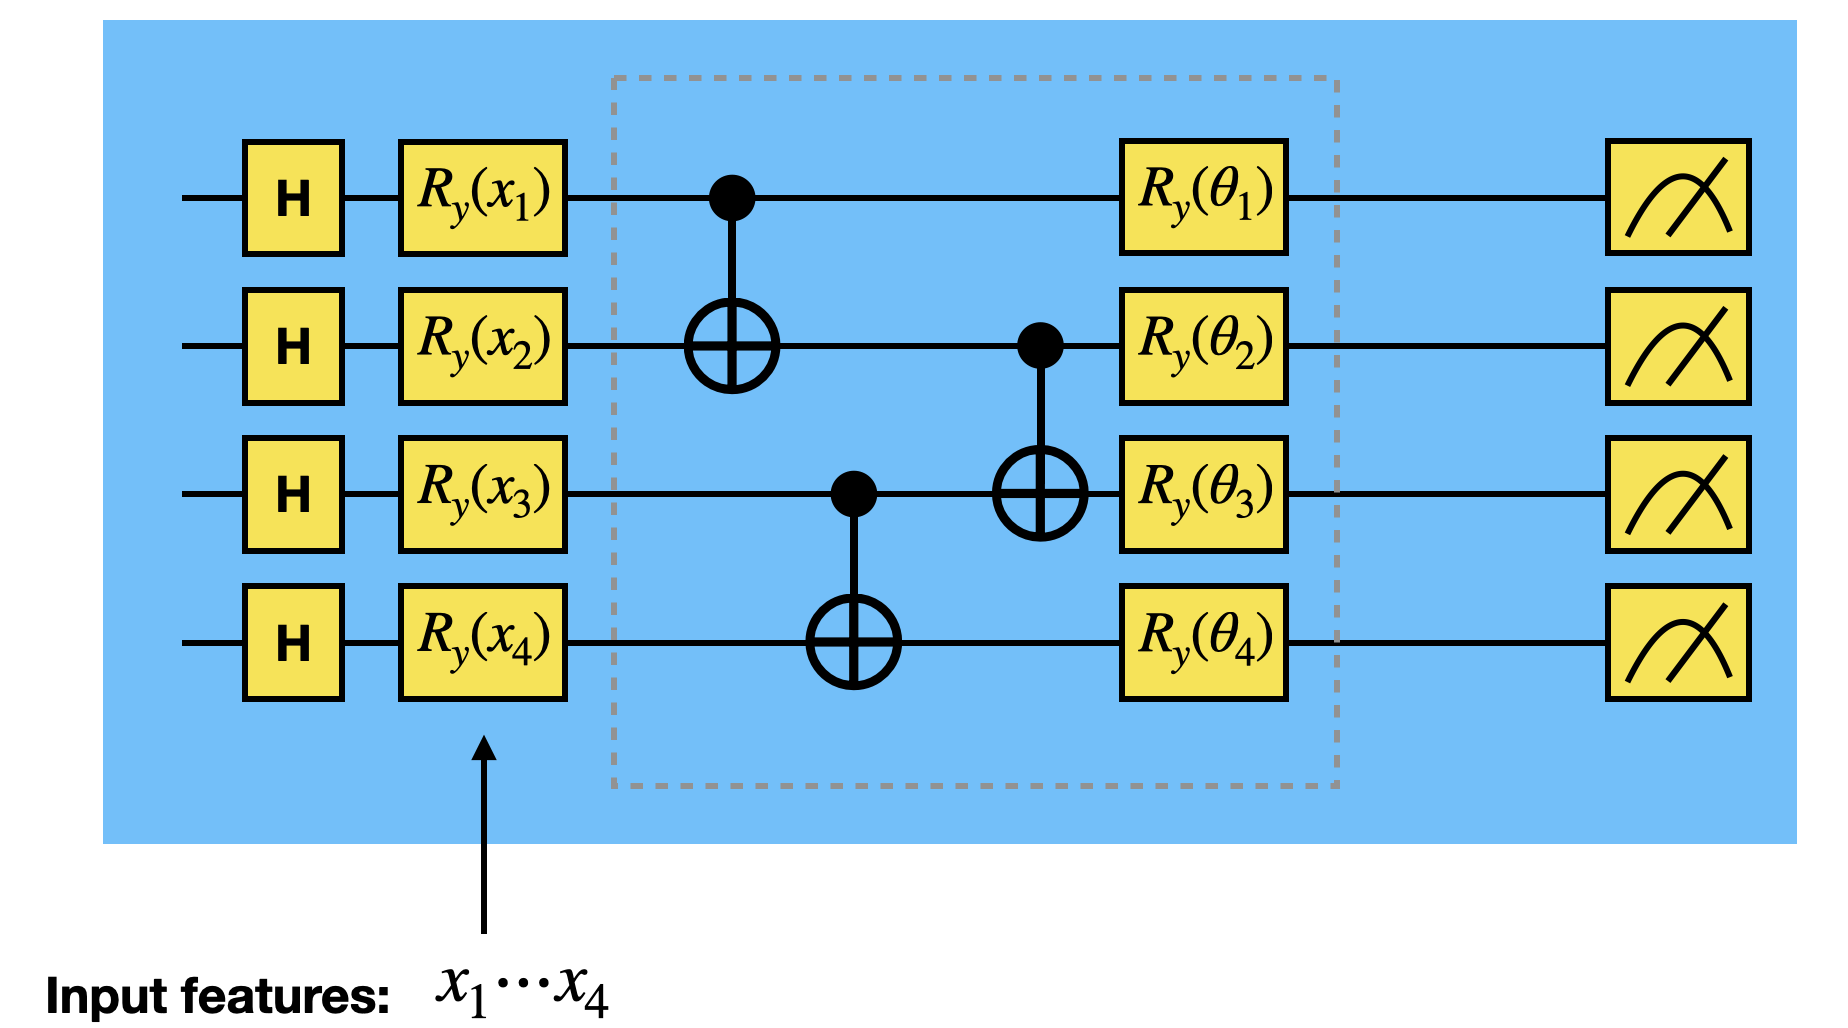

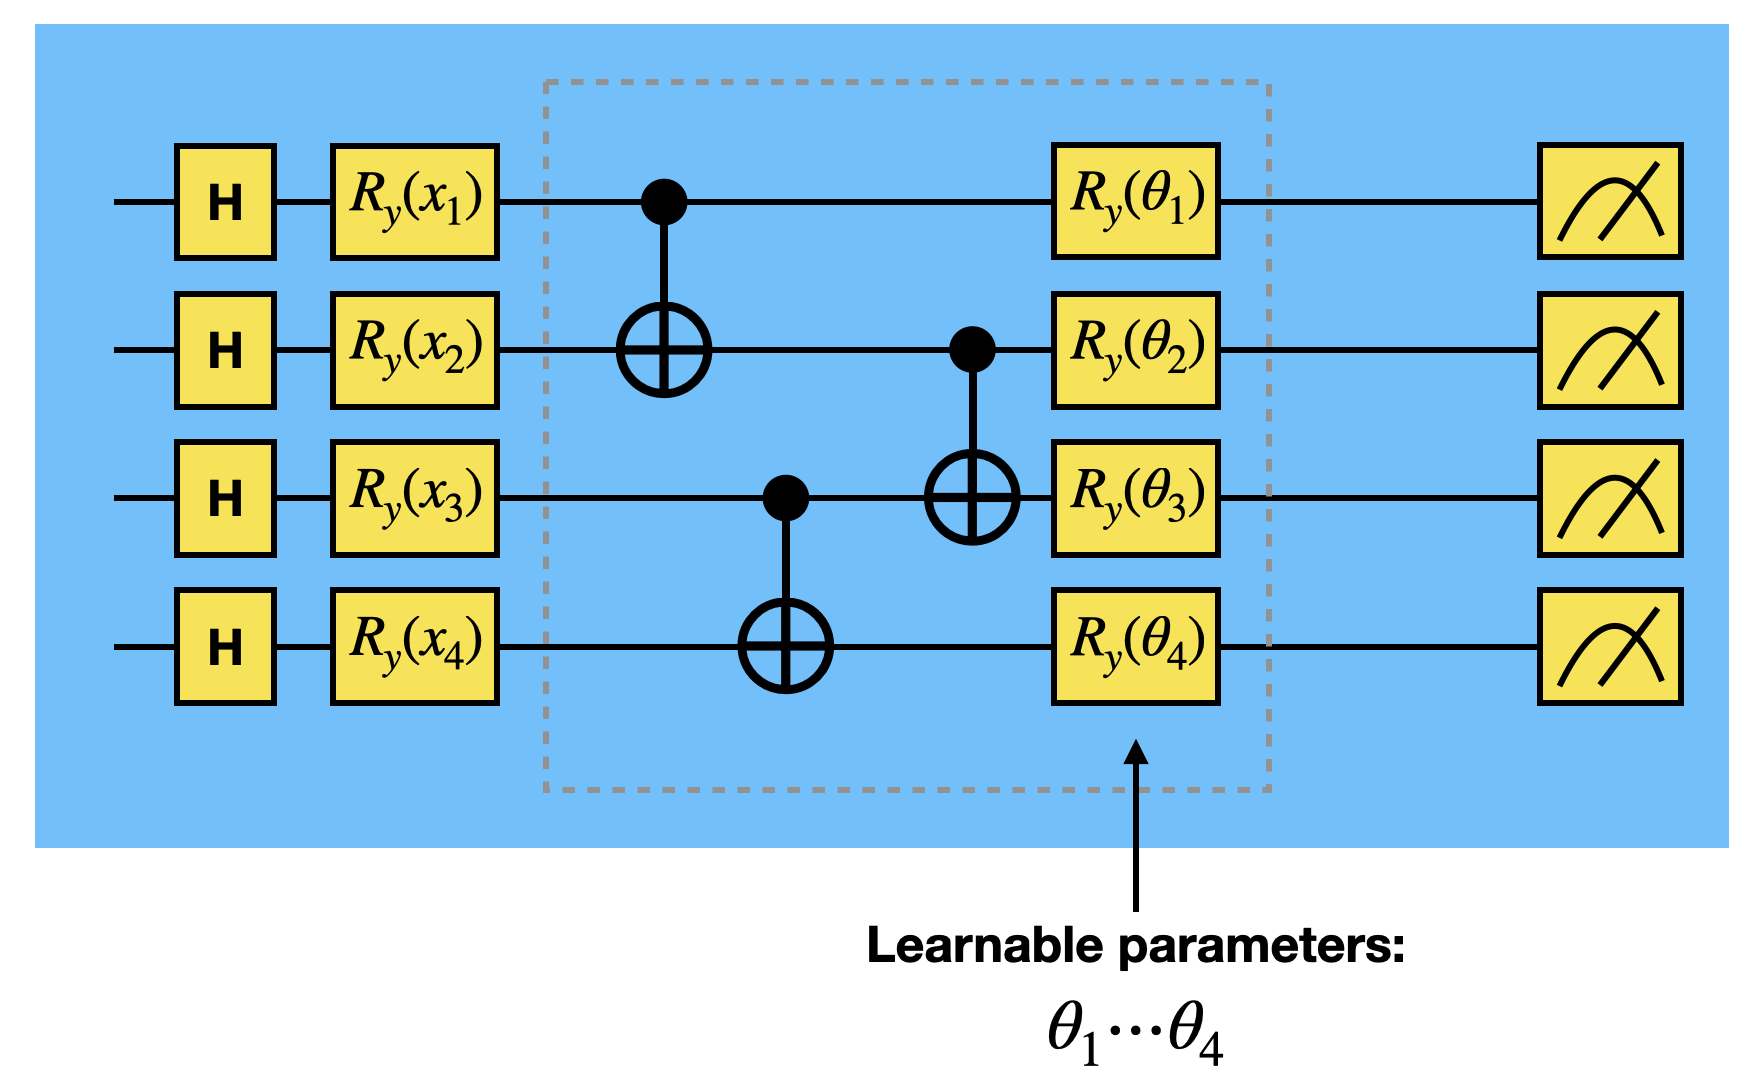

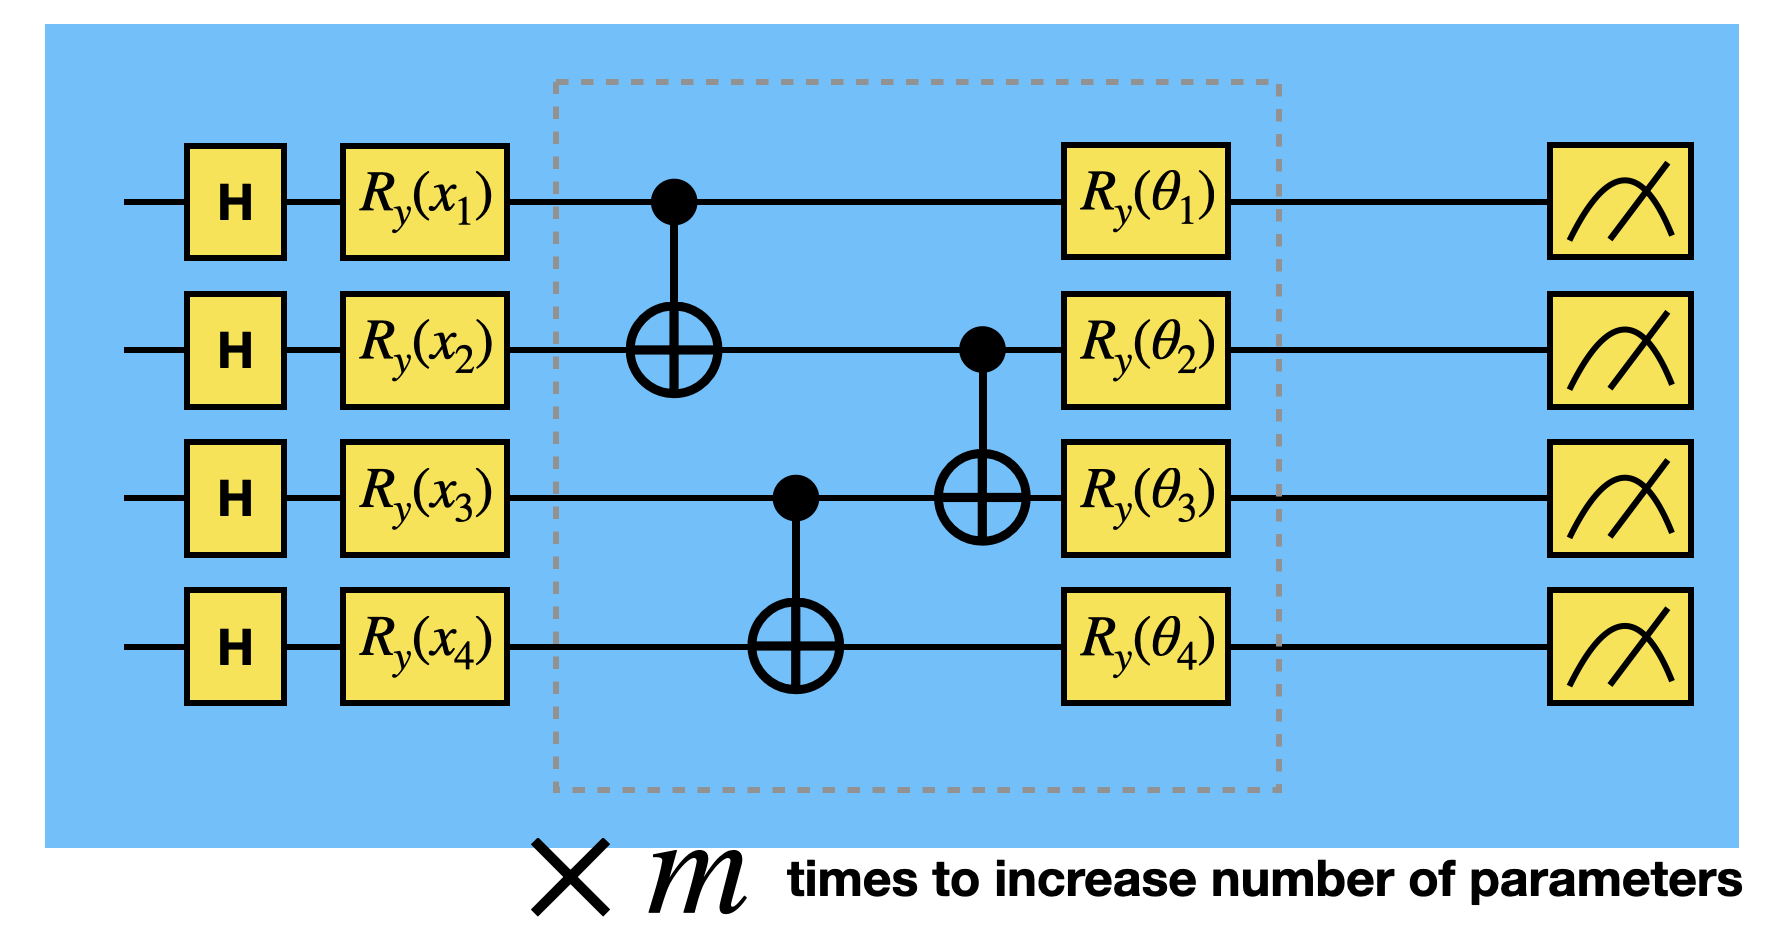

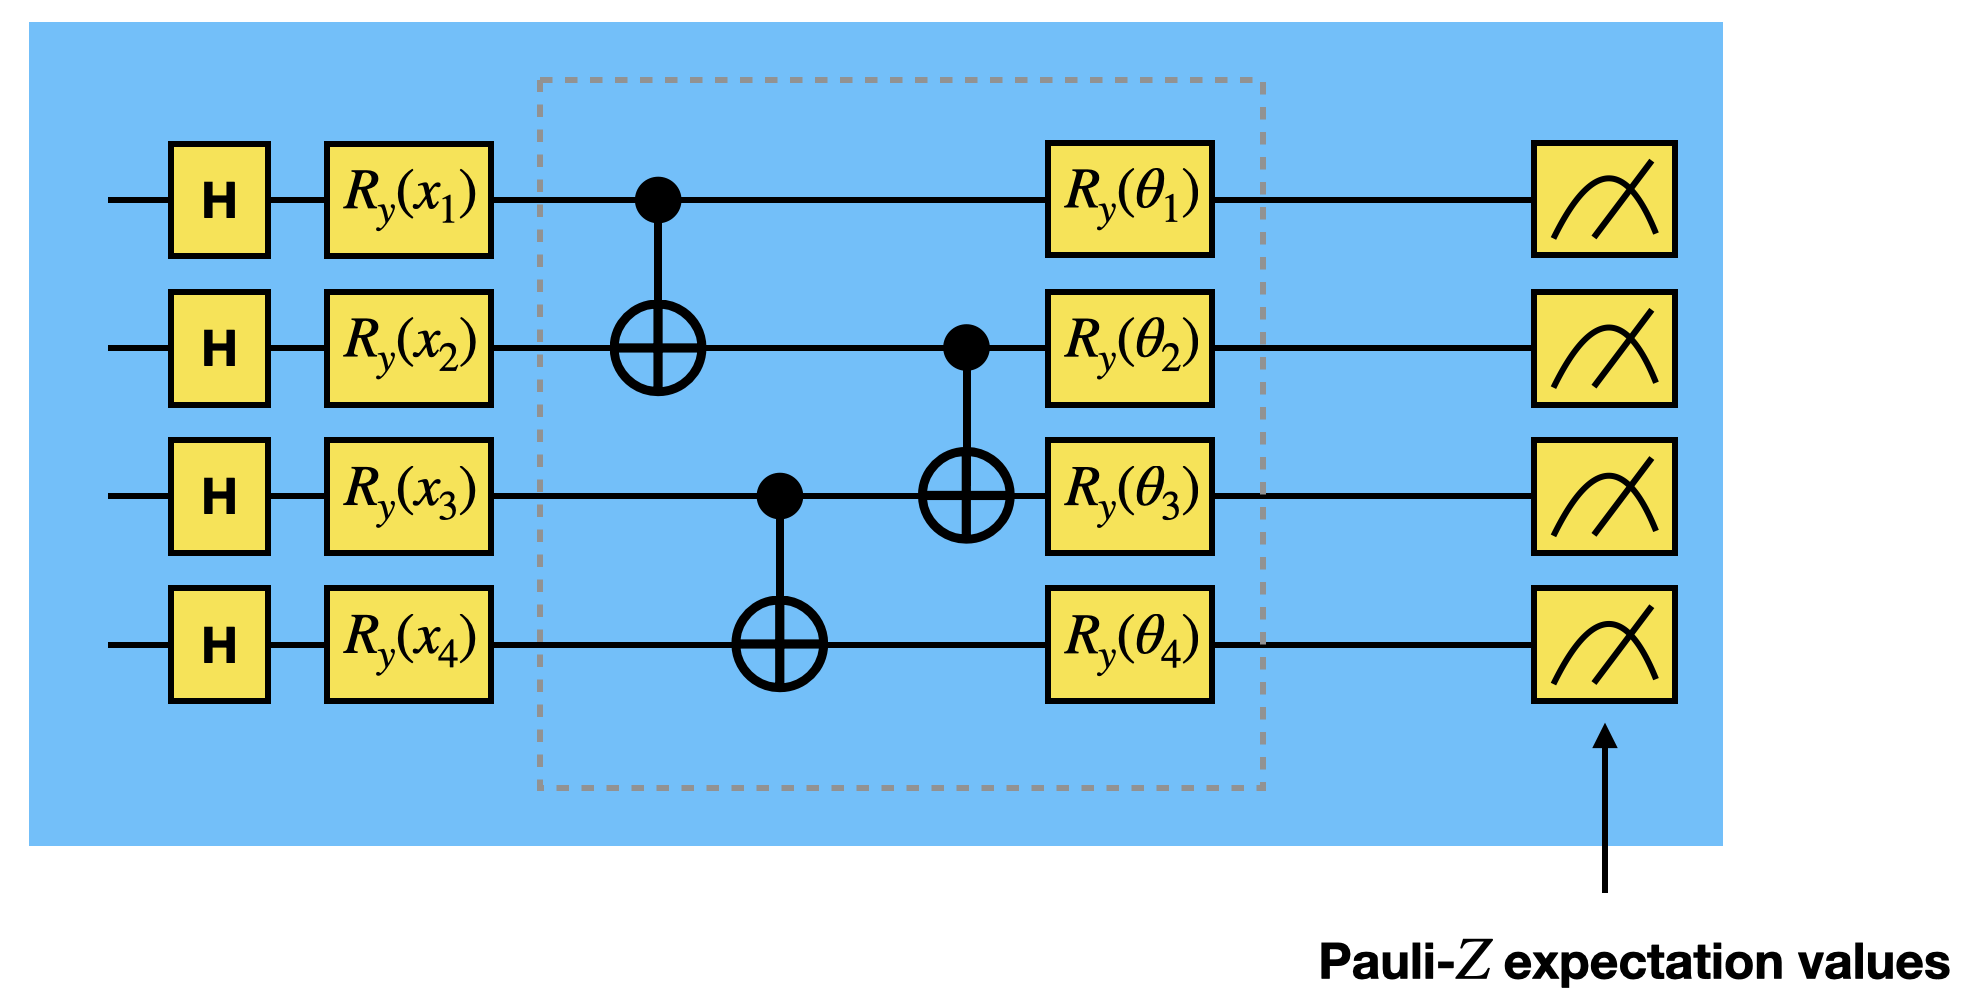

# Define basic quantum circuit components.

## Hadamard Gates

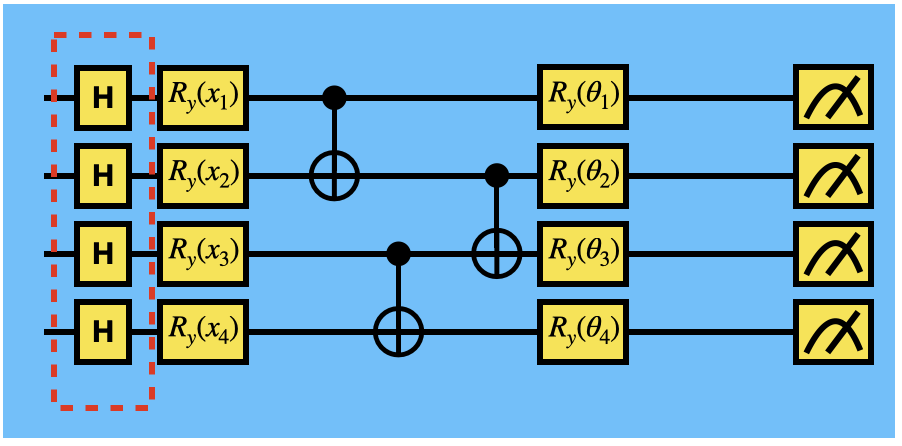

In [2]:
def H_layer(nqubits):
	"""Layer of single-qubit Hadamard gates.
	"""
	for idx in range(nqubits):
		qml.Hadamard(wires=idx)




## Y-Rotation Gates

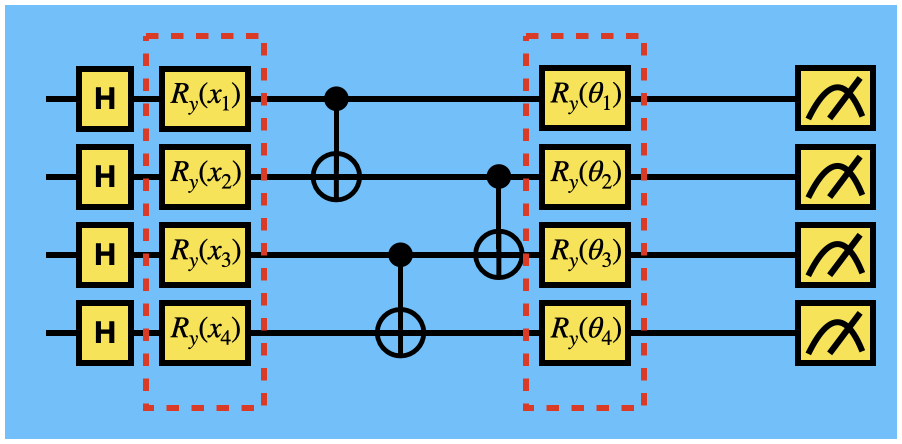

In [3]:
def RY_layer(w):
	"""Layer of parametrized qubit rotations around the y axis.
	"""
	for idx, element in enumerate(w):
		qml.RY(element, wires=idx)







## Entangling Gates

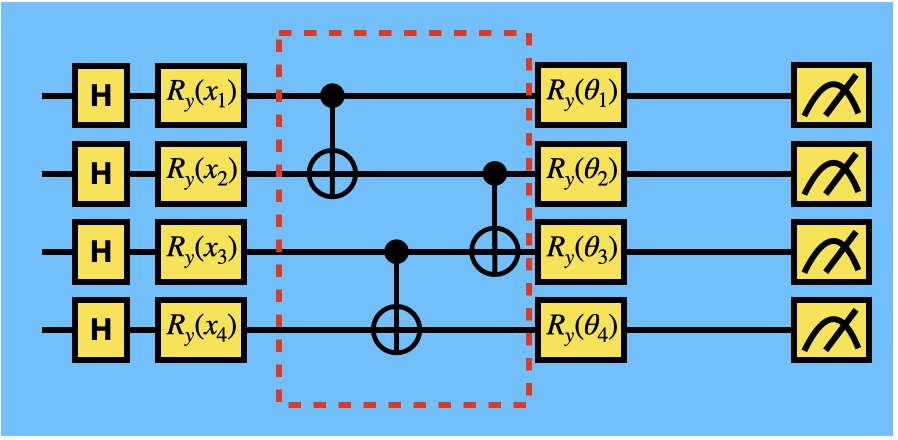

In [4]:
def entangling_layer(nqubits):
	"""Layer of CNOTs followed by another shifted layer of CNOT.
	"""
	# In other words it should apply something like :
	# CNOT  CNOT  CNOT  CNOT...  CNOT
	#   CNOT  CNOT  CNOT...  CNOT
	for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
		qml.CNOT(wires=[i, i + 1])
	for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
		qml.CNOT(wires=[i, i + 1])

# Define circuit width, depth and number of class labels

In [5]:
n_qubits = 4
q_depth = 4
n_class = 2

# Define Quantum Classifier Model

## Simulation Backend

In [6]:
dev = qml.device("default.qubit", wires=n_qubits) # Can use different simulation backend or quantum computers.

## Actual circuit architecture

In [7]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights):
	"""
	The variational quantum circuit.
	"""

	# Reshape weights
	# q_weights = q_weights_flat.reshape(q_depth, n_qubits)

	# Start from state |+> , unbiased w.r.t. |0> and |1>
	H_layer(n_qubits)

	# Embed features in the quantum node
	# print("q input features: {}".format(q_input_features))
	RY_layer(q_input_features)

	# Sequence of trainable variational layers
	for k in range(q_depth):
		entangling_layer(n_qubits)
		RY_layer(q_weights[k])

	# Expectation values in the Z basis
	exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_class)]
	return exp_vals

## Wrapped as a PyTorch Model

In [8]:
class Sequential(nn.Module):
	def __init__(self):
		super().__init__()
		self.q_params = nn.Parameter(0.01 * torch.randn(q_depth, n_qubits))


	def forward(self, batch_item):
		q_out = torch.Tensor(0, n_class)

		for elem in batch_item:
			res = torch.stack(quantum_net(elem, self.q_params))
			q_out_elem = res.float().unsqueeze(0)
			q_out = torch.cat((q_out, q_out_elem))

		return q_out

# Define the metrics of model performance

In [9]:
def accuracy(labels, predictions):
	""" Share of equal labels and predictions

	Args:
		labels (array[float]): 1-d array of labels
		predictions (array[float]): 1-d array of predictions
	Returns:
		float: accuracy
	"""

	loss = 0
	for l, p in zip(labels, predictions):
		if abs(l.item() - p) < 1e-2:
			loss = loss + 1
	loss = loss / len(labels)


	return loss

# Main Training Loop

## Prepare the dataset

In [13]:
X, y = make_moons(n_samples=300, random_state=0, noise=0.1)

print(X)
print(y)

[[ 2.04271531  0.51812416]
 [ 1.72033708 -0.13233804]
 [-0.26386729  0.76382643]
 ...
 [ 0.33823662 -0.43099924]
 [ 0.1269428   0.09966251]
 [ 0.54241537 -0.47450809]]
[1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 0 1 1
 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 1 0
 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0
 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0
 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1
 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1
 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1
 0 1 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 0
 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0
 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0
 0 1 1 

## Show the dataset

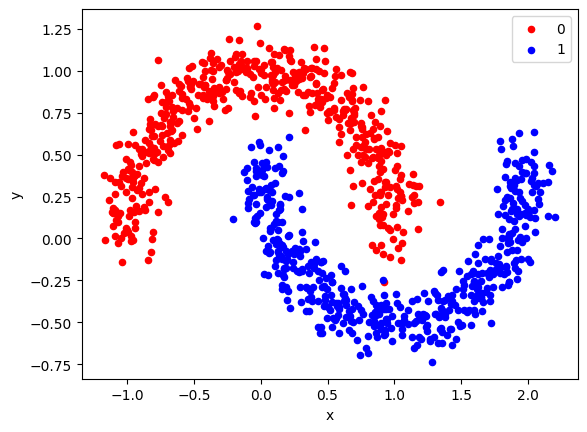

In [14]:
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

## Split the dataset

In [18]:
X = torch.from_numpy(np.concatenate((X, X), axis=1)) # For 2 features
y = torch.from_numpy(y)

x_for_train = X[:200]
y_for_train = y[:200]


x_for_test = X[200:300]
y_for_test = y[200:300]

## Initialize the model

In [19]:
VQC = Sequential()

## Initialize the optimizer

In [20]:
opt = torch.optim.RMSprop(VQC.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

## Define the training

In [21]:
num_epochs = 100
batch_size = 10

## Training

In [22]:
for epoch in range(num_epochs):
    losses = []
    for beg_i in range(0, x_for_train.shape[0], batch_size):
        X_train_batch = x_for_train[beg_i:beg_i + batch_size]
        Y_train_batch = y_for_train[beg_i:beg_i + batch_size]

        since_batch = time.time()
        opt.zero_grad()

        criterion = nn.CrossEntropyLoss()
        predict = VQC.forward(X_train_batch)
        loss = criterion(predict, Y_train_batch)

        loss.backward()
        losses.append(loss.data.cpu().numpy())
        opt.step()

    losses = np.array(losses)

    predictions_test = torch.argmax(VQC.forward(x_for_test), dim = 1)

    acc = accuracy(predictions_test, y_for_test)
    print("Epoch-{} with acc :{}".format(epoch, acc))

Epoch-0 with acc :0.85
Epoch-1 with acc :0.89
Epoch-2 with acc :0.89
Epoch-3 with acc :0.89
Epoch-4 with acc :0.9
Epoch-5 with acc :0.9
Epoch-6 with acc :0.91
Epoch-7 with acc :0.91
Epoch-8 with acc :0.91
Epoch-9 with acc :0.91
Epoch-10 with acc :0.91
Epoch-11 with acc :0.91
Epoch-12 with acc :0.91
Epoch-13 with acc :0.91
Epoch-14 with acc :0.91
Epoch-15 with acc :0.91
Epoch-16 with acc :0.91
Epoch-17 with acc :0.91
Epoch-18 with acc :0.91
Epoch-19 with acc :0.91
Epoch-20 with acc :0.91
Epoch-21 with acc :0.91
Epoch-22 with acc :0.91
Epoch-23 with acc :0.91
Epoch-24 with acc :0.91
Epoch-25 with acc :0.93
Epoch-26 with acc :0.93
Epoch-27 with acc :0.93
Epoch-28 with acc :0.93
Epoch-29 with acc :0.93
Epoch-30 with acc :0.93
Epoch-31 with acc :0.93
Epoch-32 with acc :0.93
Epoch-33 with acc :0.93
Epoch-34 with acc :0.93
Epoch-35 with acc :0.93
Epoch-36 with acc :0.93
Epoch-37 with acc :0.93
Epoch-38 with acc :0.94
Epoch-39 with acc :0.94
Epoch-40 with acc :0.94
Epoch-41 with acc :0.94
Epoc



---



---



# Simple QNN for function approximation

In [ ]:
import time

from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
from pandas import DataFrame

import warnings
import torch
import torch.nn as nn

import pennylane as qml
from pennylane import numpy as np

In [ ]:
def H_layer(nqubits):
	"""Layer of single-qubit Hadamard gates.
	"""
	for idx in range(nqubits):
		qml.Hadamard(wires=idx)


def RY_layer(w):
	"""Layer of parametrized qubit rotations around the y axis.
	"""
	for idx, element in enumerate(w):
		qml.RY(element, wires=idx)


def entangling_layer(nqubits):
	"""Layer of CNOTs followed by another shifted layer of CNOT.
	"""
	# In other words it should apply something like :
	# CNOT  CNOT  CNOT  CNOT...  CNOT
	#   CNOT  CNOT  CNOT...  CNOT
	for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
		qml.CNOT(wires=[i, i + 1])
	for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
		qml.CNOT(wires=[i, i + 1])

In [ ]:
n_qubits = 4
q_depth = 4
n_class = 1

dev = qml.device("default.qubit", wires=n_qubits)

In [ ]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights):
	"""
	The variational quantum circuit.
	"""

	# Reshape weights
	# q_weights = q_weights_flat.reshape(q_depth, n_qubits)

	# Start from state |+> , unbiased w.r.t. |0> and |1>
	H_layer(n_qubits)

	# Embed features in the quantum node
	# print("q input features: {}".format(q_input_features))
	RY_layer(q_input_features)

	# Sequence of trainable variational layers
	for k in range(q_depth):
		entangling_layer(n_qubits)
		RY_layer(q_weights[k])

	# Expectation values in the Z basis
	exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_class)]
	return exp_vals

In [ ]:
class Sequential(nn.Module):
	def __init__(self):
		super().__init__()
		self.q_params = nn.Parameter(0.01 * torch.randn(q_depth, n_qubits))


	def forward(self, batch_item):
		q_out = torch.Tensor(0, n_class)

		for elem in batch_item:
            # res = torch.stack(quantum_net(elem, self.q_params))
			q_out_elem = torch.stack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
			q_out = torch.cat((q_out, q_out_elem))

		return q_out

In [ ]:
def accuracy(labels, predictions):
	""" Share of equal labels and predictions

	Args:
		labels (array[float]): 1-d array of labels
		predictions (array[float]): 1-d array of predictions
	Returns:
		float: accuracy
	"""

	loss = 0
	for l, p in zip(labels, predictions):
		if abs(l.item() - p) < 1e-2:
			loss = loss + 1
	loss = loss / len(labels)


	return loss

[-3.         -2.97993311 -2.95986622 -2.93979933 -2.91973244 -2.89966555
 -2.87959866 -2.85953177 -2.83946488 -2.81939799 -2.7993311  -2.77926421
 -2.75919732 -2.73913043 -2.71906355 -2.69899666 -2.67892977 -2.65886288
 -2.63879599 -2.6187291  -2.59866221 -2.57859532 -2.55852843 -2.53846154
 -2.51839465 -2.49832776 -2.47826087 -2.45819398 -2.43812709 -2.4180602
 -2.39799331 -2.37792642 -2.35785953 -2.33779264 -2.31772575 -2.29765886
 -2.27759197 -2.25752508 -2.23745819 -2.2173913  -2.19732441 -2.17725753
 -2.15719064 -2.13712375 -2.11705686 -2.09698997 -2.07692308 -2.05685619
 -2.0367893  -2.01672241 -1.99665552 -1.97658863 -1.95652174 -1.93645485
 -1.91638796 -1.89632107 -1.87625418 -1.85618729 -1.8361204  -1.81605351
 -1.79598662 -1.77591973 -1.75585284 -1.73578595 -1.71571906 -1.69565217
 -1.67558528 -1.65551839 -1.63545151 -1.61538462 -1.59531773 -1.57525084
 -1.55518395 -1.53511706 -1.51505017 -1.49498328 -1.47491639 -1.4548495
 -1.43478261 -1.41471572 -1.39464883 -1.37458194 -1.3

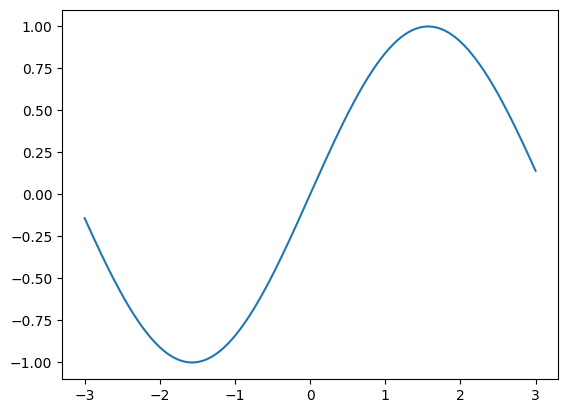

tensor([[0.1090],
        [0.1291],
        [0.1491],
        [0.1691],
        [0.1890]], grad_fn=<CatBackward0>)
Epoch-0 with MSE :1.4525951147079468
Epoch-1 with MSE :1.3444104194641113
Epoch-2 with MSE :1.299314260482788
Epoch-3 with MSE :1.2598276138305664
Epoch-4 with MSE :1.2100653648376465
Epoch-5 with MSE :1.1424528360366821
Epoch-6 with MSE :1.0532926321029663
Epoch-7 with MSE :0.9435594081878662
Epoch-8 with MSE :0.8199004530906677
Epoch-9 with MSE :0.6930944323539734
Epoch-10 with MSE :0.5740638971328735
Epoch-11 with MSE :0.4702330529689789
Epoch-12 with MSE :0.38443827629089355
Epoch-13 with MSE :0.31602802872657776
Epoch-14 with MSE :0.26258134841918945
Epoch-15 with MSE :0.22120971977710724
Epoch-16 with MSE :0.18924038112163544
Epoch-17 with MSE :0.1644577533006668
Epoch-18 with MSE :0.14511847496032715
Epoch-19 with MSE :0.12987707555294037
Epoch-20 with MSE :0.11768919974565506
Epoch-21 with MSE :0.10772252827882767
Epoch-22 with MSE :0.09928257763385773
Epoch-23 wit

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
# Prepare the dataset
# X, y = make_moons(n_samples=300, random_state=0, noise=0.1)
X = np.linspace(-3, 3, 300)
y = np.sin(X)

print(X)
print(y)

plt.plot(X, y)
plt.show()

# Split the dataset
X = np.reshape(X, (X.shape[0],1))
X = torch.from_numpy(np.concatenate((X, X, X, X), axis=1)) # For 2 features
y = torch.from_numpy(y).float()

x_for_train = X[:200]
y_for_train = y[:200]


x_for_test = X[200:300]
y_for_test = y[200:300]


VQC = Sequential()


opt = torch.optim.RMSprop(VQC.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

print(VQC.forward(X[0:5]))

# Training

num_epochs = 100
batch_size = 10

for epoch in range(num_epochs):
    losses = []
    for beg_i in range(0, x_for_train.shape[0], batch_size):
        X_train_batch = x_for_train[beg_i:beg_i + batch_size]
        Y_train_batch = y_for_train[beg_i:beg_i + batch_size]

        since_batch = time.time()
        opt.zero_grad()

        criterion = nn.MSELoss()
        predict = VQC.forward(X_train_batch)
        loss = criterion(predict.view(-1), Y_train_batch)

        loss.backward()
        losses.append(loss.data.cpu().numpy())
        opt.step()

    losses = np.array(losses)

    predictions_test = VQC.forward(x_for_test)

    # plot
    plt.plot(X, VQC.forward(X).view(-1).detach().numpy())
    plt.plot(X, y)
    plt.axvline(x=1, color='r', linestyle='--')
    plt.title("VQC approximate sin(x)")
    plt.savefig('function_approximate_results_epoch_{}.pdf'.format(epoch), format = 'pdf')
    plt.clf()

    ##

    # print("Prediction test: {}".format(predictions_test))
    acc = criterion(predictions_test.view(-1), y_for_test)
    print("Epoch-{} with MSE :{}".format(epoch, acc))



---



---



# Quantum Fast Weight Programmers

# Chen, S. Y. C. (2024). *Learning to Program Variational Quantum Circuits with Fast Weights*. arXiv preprint arXiv:2402.17760.




---



# The idea of Fast Weight Programmers

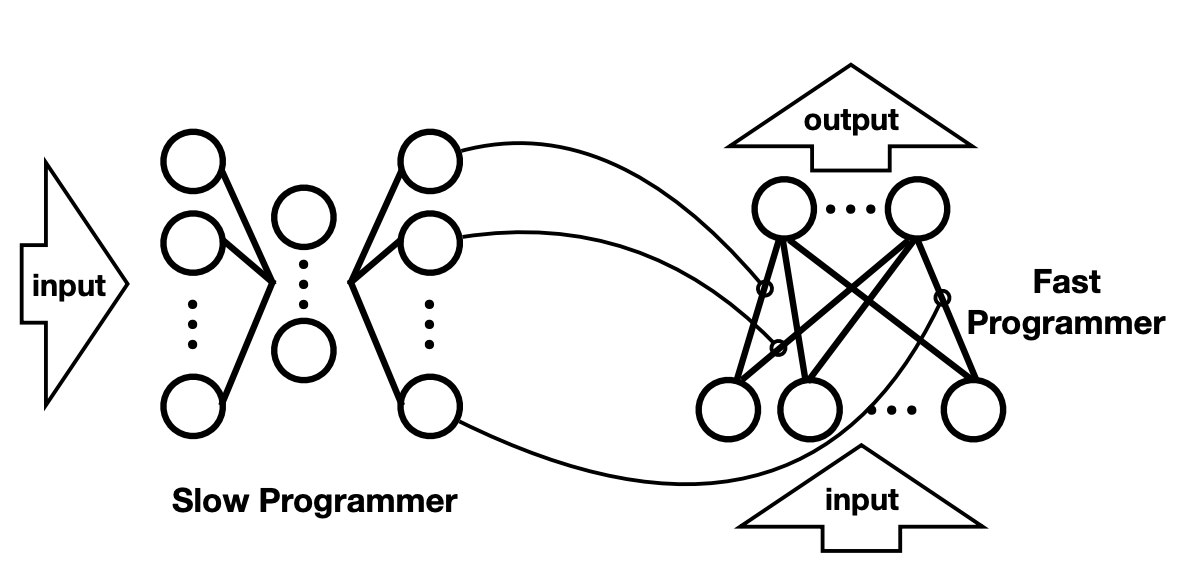

# Quantum FWP

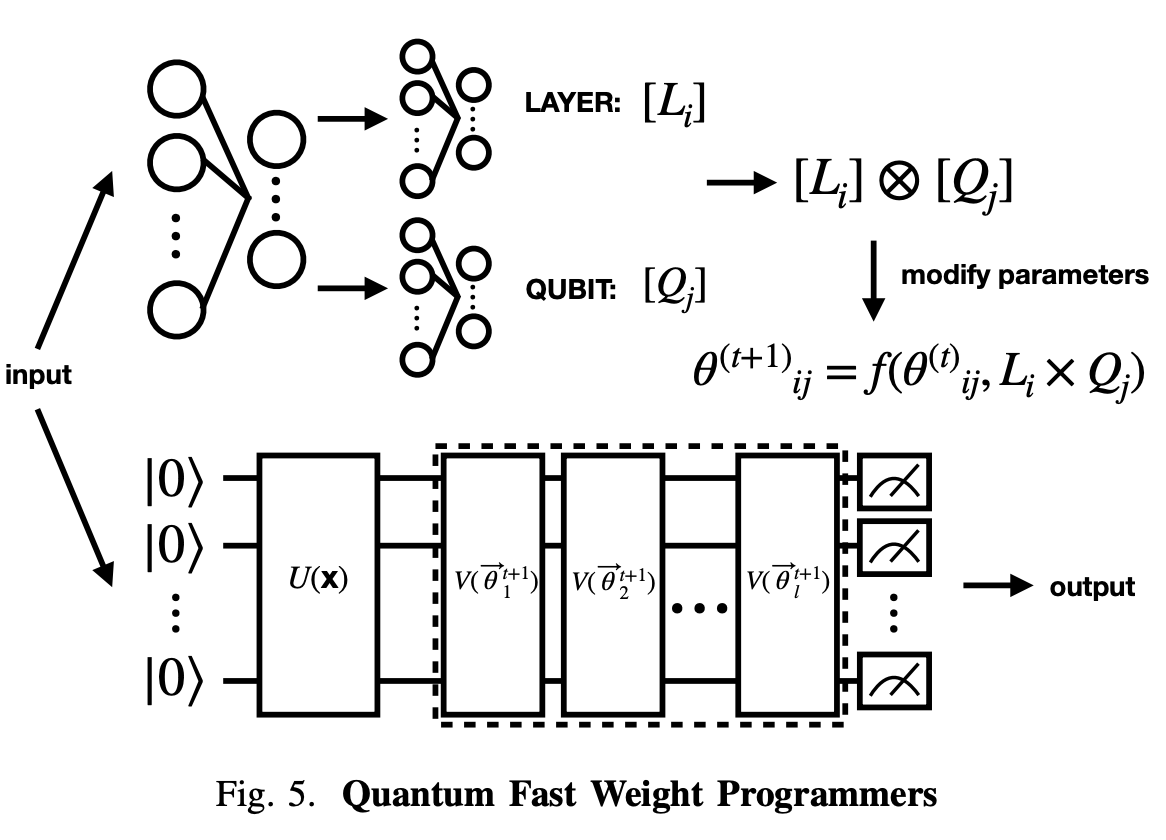

## Prepare the data- Damped SHM


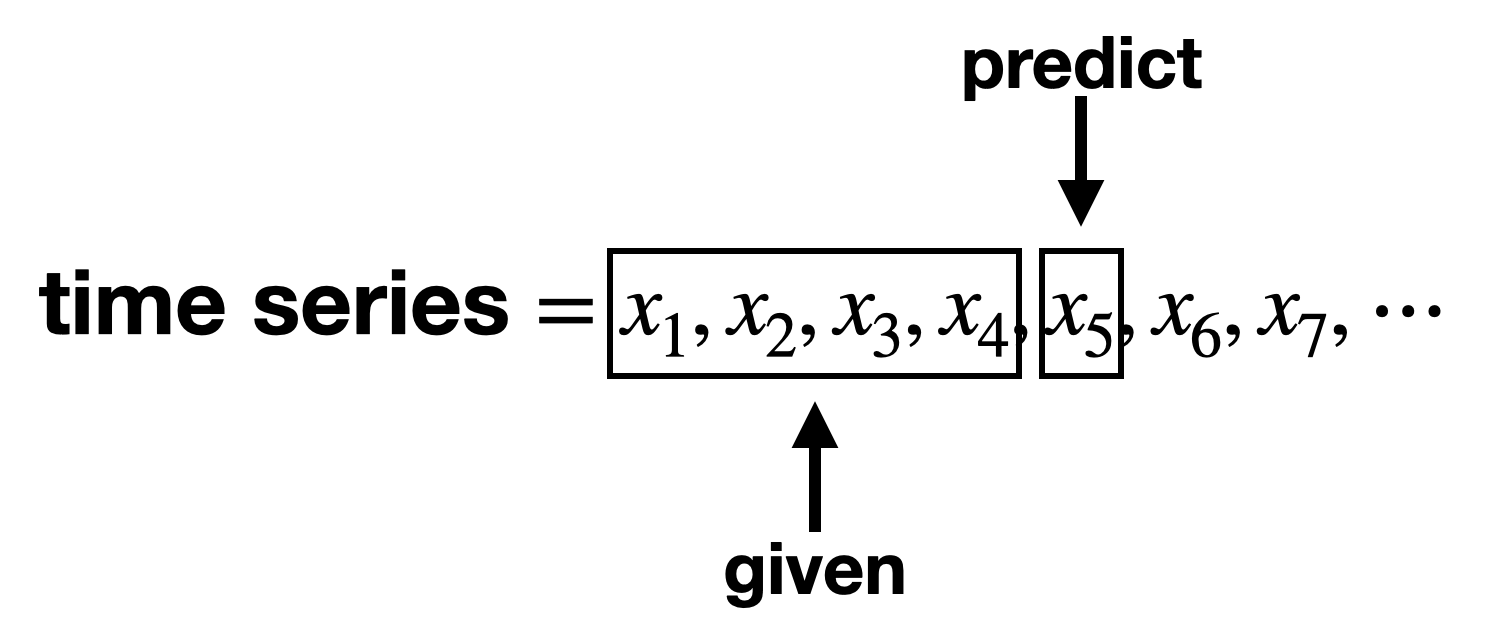

In [ ]:
import numpy as np
from scipy.integrate import odeint
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler

def system(theta,t,b,g,l,m):
	theta1 = theta[0]
	theta2 = theta[1]
	dtheta1_dt = theta2
	dtheta2_dt = -(b/m)*theta2-g*math.sin(theta1)
	dtheta_dt=[dtheta1_dt,dtheta2_dt]

	return dtheta_dt



b=0.15
g=9.81
l=1
m=1


theta_0 = [0,3]


t = np.linspace(0,20,240)


theta = odeint(system,theta_0,t,args = (b,g,l,m))



# f=1
# for i in range(0,240):
# 	filename = str(f)+'.png'
# 	f= f+1
# 	plt.figure()
# 	plt.plot([10,l*math.sin(theta[i,0])+10],[10,10-l*math.cos(theta[i,0])],marker="o")
# 	plt.xlim([0,20])
# 	plt.ylim([0,20])


# 	plt.savefig(filename)

# Plotting
# plt.plot(t,theta[:,0],'b-')
# plt.plot(t,theta[:,1],'r--')
# plt.show()

# normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(theta[:,1].reshape(-1, 1))


def plotting_test(x, data_src):
	# create a figure window
	fig = plt.figure(1, figsize=(9,8))
	ax1 = fig.add_subplot()
	ax1.plot(x,data_src)
	ax1.axhline(color="grey", ls="--", zorder=-1)
	ax1.set_ylim(-1,1)
	ax1.text(0.5, 0.95,'Damped SHM', ha='center', va='top',
		 transform = ax1.transAxes)

	plt.show()

def transform_data_single_predict(data, seq_length):
	x = []
	y = []

	for i in range(len(data)-seq_length-1):
		_x = data[i:(i+seq_length)]
		_y = data[i+seq_length]
		x.append(_x)
		y.append(_y)
	x_var = Variable(torch.from_numpy(np.array(x).reshape(-1, seq_length)).float())
	y_var = Variable(torch.from_numpy(np.array(y)).float())

	return x_var, y_var



def get_damped_shm_data(data = dataset, seq_len = 4):
	return transform_data_single_predict(data = data, seq_length = seq_len)



---



In [ ]:
# Datetime
from datetime import datetime
import time

# Saving
import pickle
import os
import copy

from functools import *

# Generic VQC structure

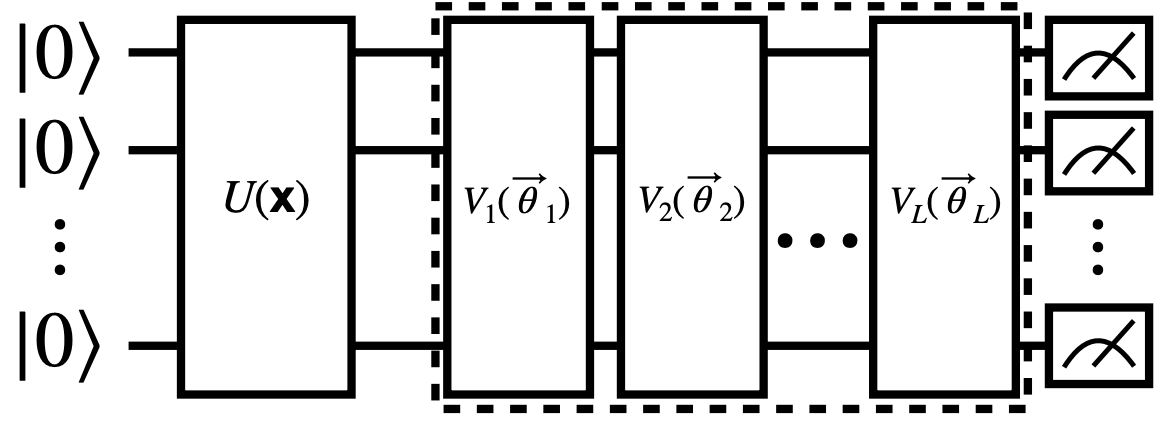

# VQC used in Quantum FWP

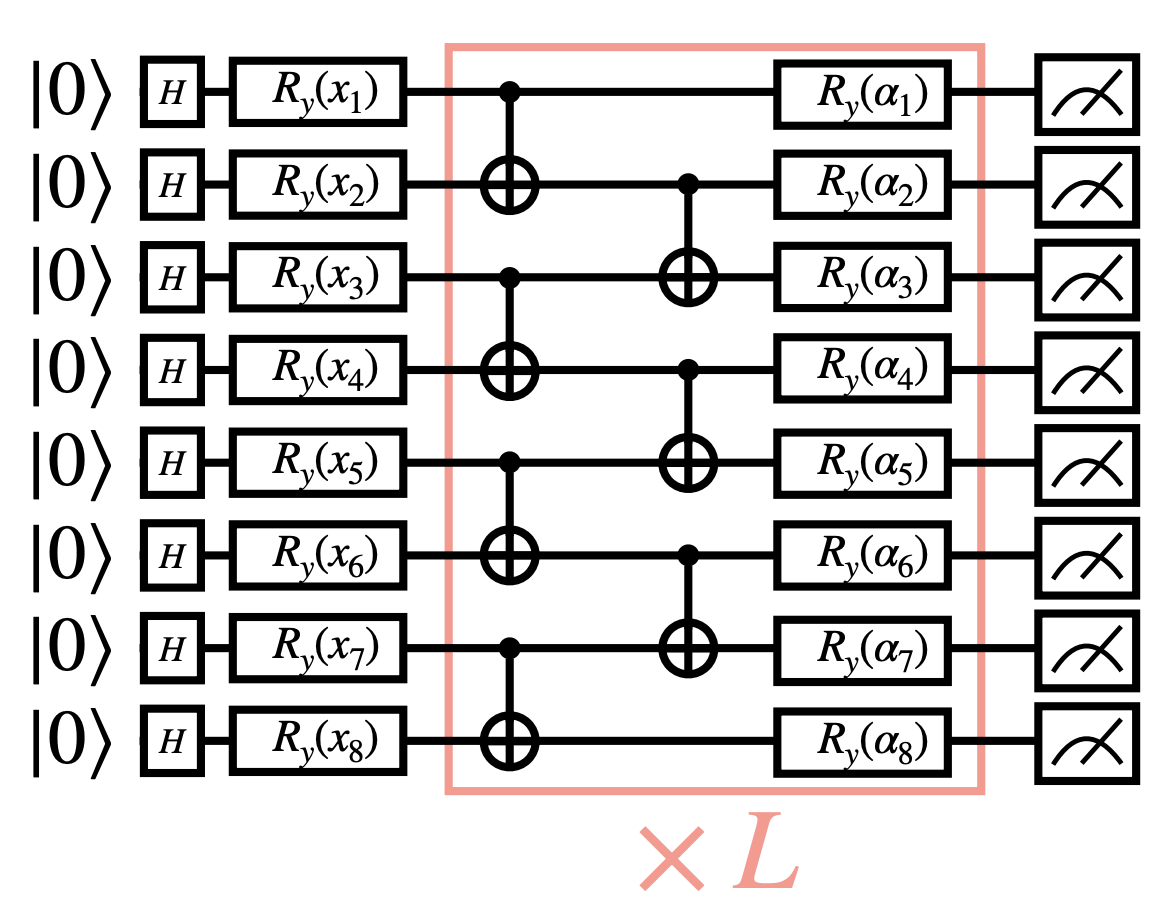

## Define the VQC function

In [ ]:
def quantum_net(inputs, q_weights, n_outputs):
	n_dep = q_weights.shape[0]
	n_qub = q_weights.shape[1]

	H_layer(n_qub)

	RY_layer(inputs)

	for k in range(n_dep):
		entangling_layer(n_qub)
		RY_layer(q_weights[k])

	# Expectation values in the Z basis
	# exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_class)]
	# return tuple(exp_vals)
	return [qml.expval(qml.PauliZ(position)) for position in range(n_outputs)]

## Helper functions

In [ ]:
class HideSignature:
	def __init__(self, partial_func):
		self.partial_func = partial_func

	def __call__(self, inputs, q_weights):
		return self.partial_func(inputs, q_weights)

##############

### VQC batch wrapper

class BatchVQC:
	def __init__(self, q_func):
		self.q_func = q_func

	def __call__(self, inputs, q_weights):

		res_all = []
		for input_item, q_weight_item in zip(inputs, q_weights):
			res = self.q_func(input_item, q_weight_item) # not yet consider the memory of previous time-step
			# print(qml.draw(self.q_func)(inputs=input_item, q_weights=q_weight_item))
			# print(res)
			# print(type(res))
			res_all.append(torch.stack(res)) # 2024 05 06: For PyTorch 2.2, torch.stack function.

		return torch.stack(res_all)

## Quantum FWP Cell Module

## $L$: layer index
## $Q$: qubit index

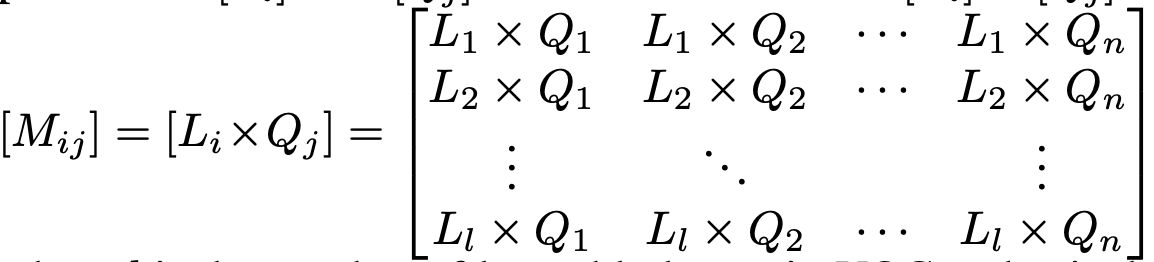

In [ ]:
class FWPCell(nn.Module):
	def __init__(self, s_dim, a_dim):
		super().__init__()

		latent_dim = 8
		self.n_qubits = latent_dim
		self.q_depth = 2

		dev = qml.device("default.qubit", wires = self.n_qubits)
		self.q_func = BatchVQC(qml.QNode(HideSignature(partial(quantum_net, n_outputs = a_dim)), dev, interface = "torch"))

		self.slow_program_encoder = torch.nn.Linear(s_dim, latent_dim)
		self.slow_program_layer_idx = torch.nn.Linear(latent_dim, self.q_depth)
		self.slow_program_qubit_idx = torch.nn.Linear(latent_dim, self.n_qubits)

		self.post_processing = torch.nn.Linear(a_dim, 1)



	def forward(self, batch_item, previous_circuit_param):
		res = self.slow_program_encoder(batch_item)

		res_layer_idx = self.slow_program_layer_idx(res)
		res_qubit_idx = self.slow_program_qubit_idx(res)

		# Calculate the VQC params
		out_circuit_params = []
		for layer_idx, qubit_idx in zip(res_layer_idx, res_qubit_idx):
			outer_product = torch.outer(layer_idx, qubit_idx)
			# print("outer_product: {}".format(outer_product))
			out_circuit_params.append(outer_product)
		out_circuit_params = torch.stack(out_circuit_params)

		# Add of previous_circuit_param and out_circuit_params
		out_circuit_params = torch.add(out_circuit_params, previous_circuit_param)

		# Go through the VQC
		res = self.q_func(batch_item, out_circuit_params)

		res = self.post_processing(res)


		return res, out_circuit_params

	def initial_fast_params(self, batch_size):

		return torch.zeros(batch_size, self.q_depth, self.n_qubits)

## Quantum FWP Module

In [ ]:
class FWP(nn.Module):
	# FWP module: processes the whole sequence
	# (N, T, F)
	# N: number of batch
	# T: number of time-step
	# F: number of features
	def __init__(self, s_dim, a_dim):
		super().__init__()
		self.fwp_cell = FWPCell(s_dim = s_dim, a_dim = a_dim)



	def forward(self, batch_item):
		batch_size = batch_item.shape[0]
		initial_fast_params = self.fwp_cell.initial_fast_params(batch_size)
		time_length = batch_item.shape[1]

		output_collection_list = []

		for t in range(time_length):
			out_batch, initial_fast_params = self.fwp_cell(batch_item[:, t, :], initial_fast_params)
			output_collection_list.append(out_batch)

		res = torch.stack(output_collection_list)

		return res

## Training Routine

In [ ]:
def train_epoch_full(opt, model, X, Y, batch_size):
	losses = []

	for beg_i in range(0, X.shape[0], batch_size):
		X_train_batch = X[beg_i:beg_i + batch_size]
		# print(x_batch.shape)
		Y_train_batch = Y[beg_i:beg_i + batch_size]

		# opt.step(closure)
		since_batch = time.time()
		opt.zero_grad()
		# print("CALCULATING LOSS...")
		model_res = model(X_train_batch)
		loss = nn.MSELoss()
		loss_val = loss(model_res[-1], Y_train_batch)
		# print("BACKWARD..")
		loss_val.backward()
		losses.append(loss_val.data.cpu().numpy())
		opt.step()
		# print("LOSS IN BATCH: ", loss_val)
		# print("FINISHED OPT.")
		# print("Batch time: ", time.time() - since_batch)
		# print("CALCULATING PREDICTION.")
	losses = np.array(losses)
	return losses.mean()

## Plotting and Saving

In [ ]:
def saving(exp_name, exp_index, train_len, iteration_list, train_loss_list, test_loss_list, model, simulation_result, ground_truth):
	# Generate file name
	file_name = exp_name + "_NO_" + str(exp_index) + "_Epoch_" + str(iteration_list[-1])
	saved_simulation_truth = {
	"simulation_result" : simulation_result,
	"ground_truth" : ground_truth
	}

	if not os.path.exists(exp_name):
		os.makedirs(exp_name)

	# Save the train loss list
	with open(exp_name + "/" + file_name + "_TRAINING_LOST" + ".txt", "wb") as fp:
		pickle.dump(train_loss_list, fp)

	# Save the test loss list
	with open(exp_name + "/" + file_name + "_TESTING_LOST" + ".txt", "wb") as fp:
		pickle.dump(test_loss_list, fp)

	# Save the simulation result
	with open(exp_name + "/" + file_name + "_SIMULATION_RESULT" + ".txt", "wb") as fp:
		pickle.dump(saved_simulation_truth, fp)

	# Save the model parameters
	torch.save(model.state_dict(), exp_name + "/" +  file_name + "_torch_model.pth")

	# Plot
	plotting_data(exp_name, exp_index, file_name, iteration_list, train_loss_list, test_loss_list)
	plotting_simulation(exp_name, exp_index, file_name, train_len, simulation_result, ground_truth)

	return


def plotting_data(exp_name, exp_index, file_name, iteration_list, train_loss_list, test_loss_list):
	# Plot train and test loss
	fig, ax = plt.subplots()
	# plt.yscale('log')
	ax.plot(iteration_list, train_loss_list, '-b', label='Training Loss')
	ax.plot(iteration_list, test_loss_list, '-r', label='Testing Loss')
	leg = ax.legend();

	ax.set(xlabel='Epoch',
		   title=exp_name)
	fig.savefig(exp_name + "/" + file_name + "_" + "loss" + "_"+ datetime.now().strftime("NO%Y%m%d%H%M%S") + ".pdf", format='pdf')
	plt.clf()

	return

def plotting_simulation(exp_name, exp_index, file_name, train_len, simulation_result, ground_truth):
	# Plot the simulation
	plt.axvline(x=train_len, c='r', linestyle='--')
	plt.plot(simulation_result, '-')
	plt.plot(ground_truth.detach().numpy(), '--')
	plt.suptitle(exp_name)
	# savfig can only be placed BEFORE show()
	plt.savefig(exp_name + "/" + file_name + "_" + "simulation" + "_"+ datetime.now().strftime("NO%Y%m%d%H%M%S") + ".pdf", format='pdf')
	return

## Train!

x_train:  tensor([[ 1.0000,  0.9519,  0.8392,  0.6746],
        [ 0.9519,  0.8392,  0.6746,  0.4736],
        [ 0.8392,  0.6746,  0.4736,  0.2509],
        [ 0.6746,  0.4736,  0.2509,  0.0185],
        [ 0.4736,  0.2509,  0.0185, -0.2134],
        [ 0.2509,  0.0185, -0.2134, -0.4355],
        [ 0.0185, -0.2134, -0.4355, -0.6373],
        [-0.2134, -0.4355, -0.6373, -0.8069],
        [-0.4355, -0.6373, -0.8069, -0.9310],
        [-0.6373, -0.8069, -0.9310, -0.9978],
        [-0.8069, -0.9310, -0.9978, -1.0000],
        [-0.9310, -0.9978, -1.0000, -0.9376],
        [-0.9978, -1.0000, -0.9376, -0.8178],
        [-1.0000, -0.9376, -0.8178, -0.6530],
        [-0.9376, -0.8178, -0.6530, -0.4572],
        [-0.8178, -0.6530, -0.4572, -0.2437],
        [-0.6530, -0.4572, -0.2437, -0.0238],
        [-0.4572, -0.2437, -0.0238,  0.1926],
        [-0.2437, -0.0238,  0.1926,  0.3957],
        [-0.0238,  0.1926,  0.3957,  0.5746],
        [ 0.1926,  0.3957,  0.5746,  0.7176],
        [ 0.3957,  0.574

KeyboardInterrupt: 

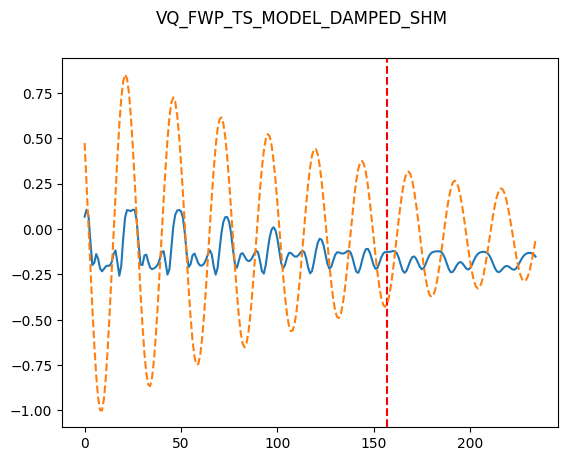

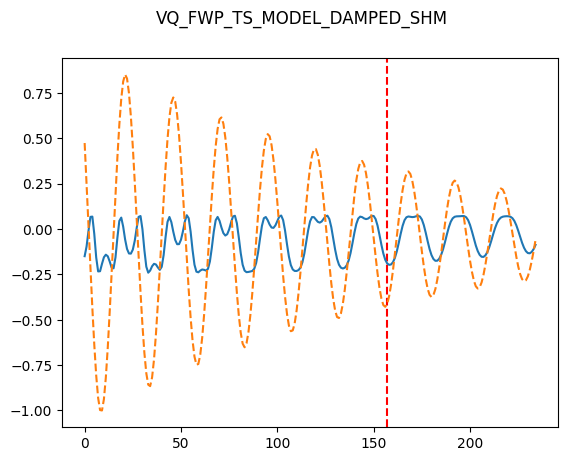

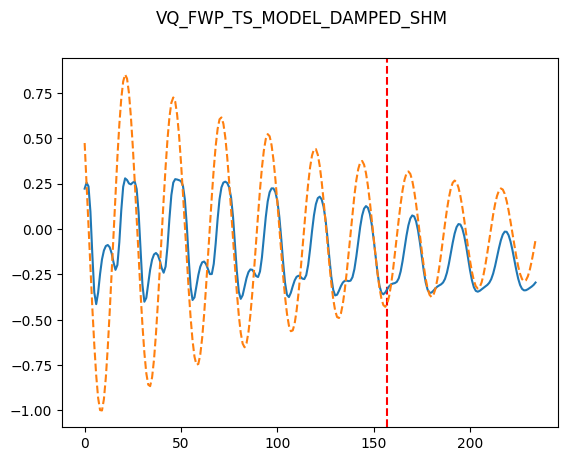

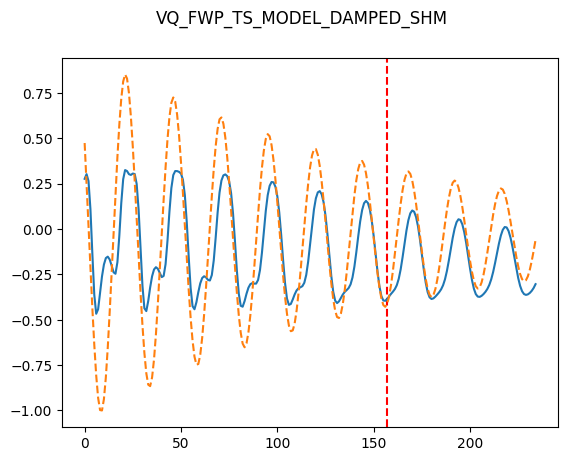

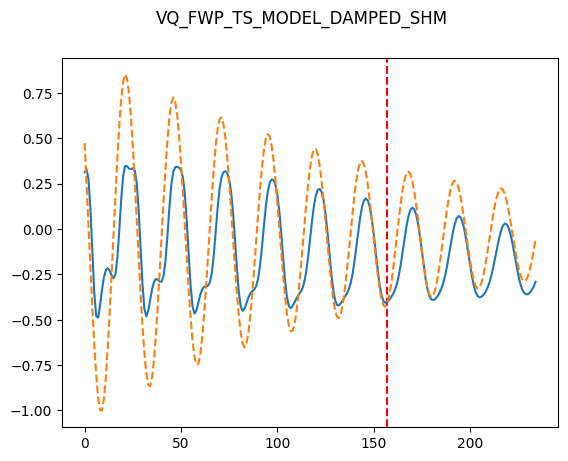

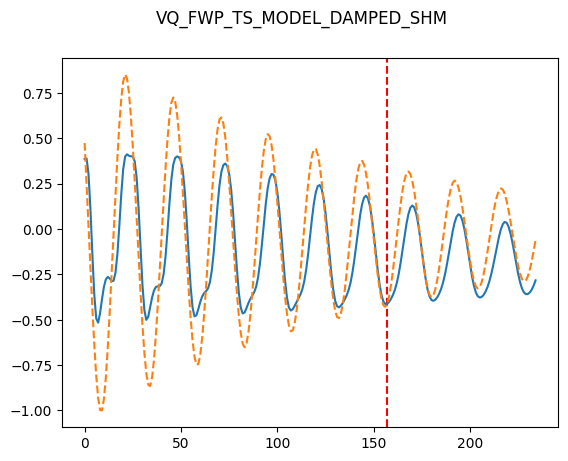

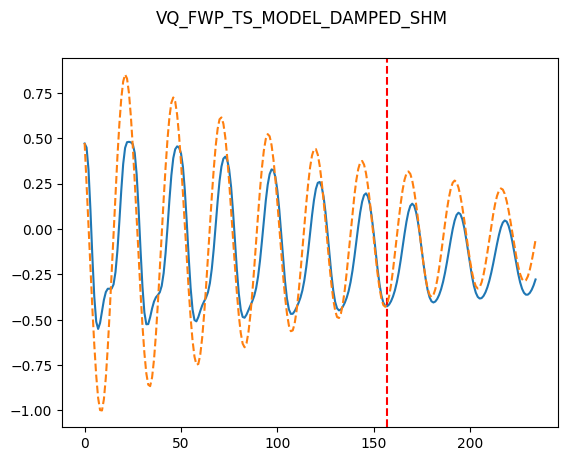

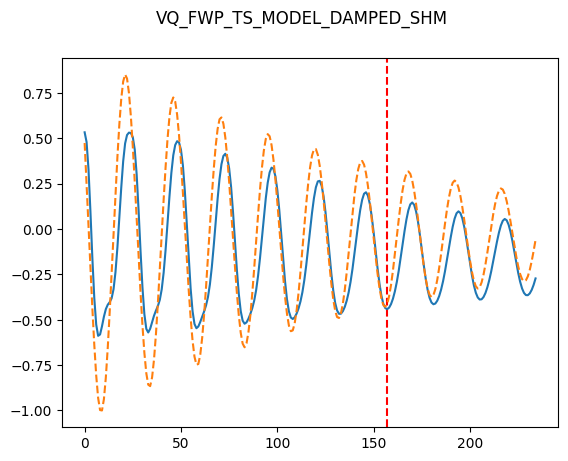

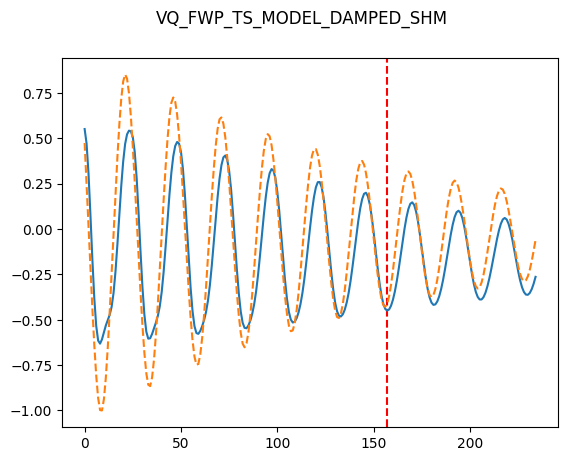

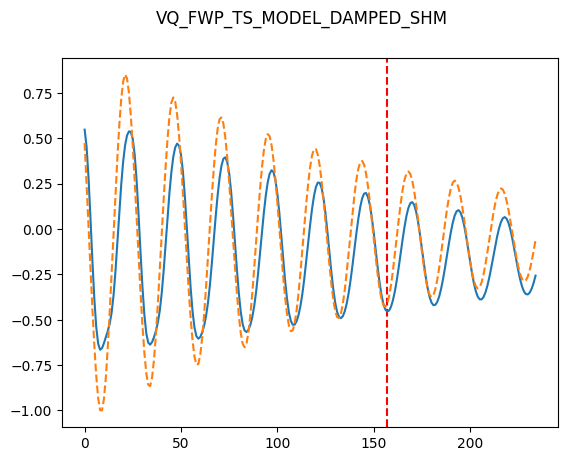

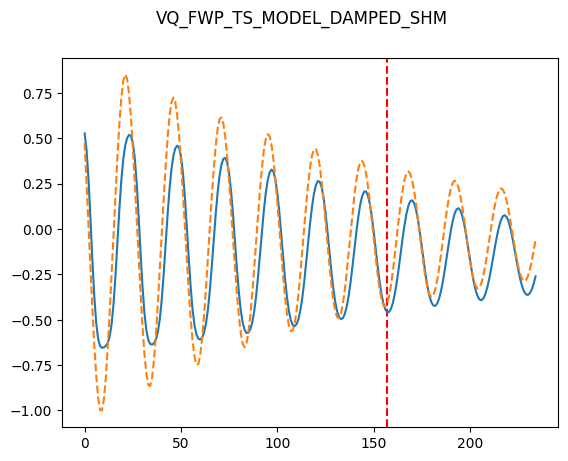

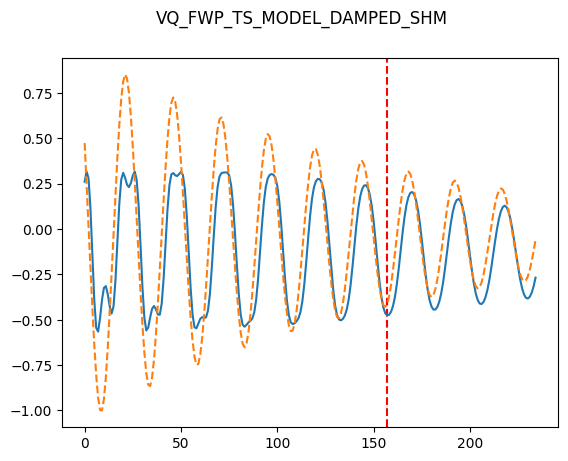

In [ ]:
dtype = torch.DoubleTensor

x, y = get_damped_shm_data()

num_for_train_set = int(0.67 * len(x))

x_train = x[:num_for_train_set].type(dtype)
y_train = y[:num_for_train_set].type(dtype)

x_test = x[num_for_train_set:].type(dtype)
y_test = y[num_for_train_set:].type(dtype)

print("x_train: ", x_train)
print("x_test: ", x_test)
print("x_train.shape: ", x_train.shape)
print("x_test.shape: ", x_test.shape)

x_train_transformed = x_train.unsqueeze(2)
x_test_transformed = x_test.unsqueeze(2)

print("x_train: ", x_train_transformed)
print("x_test: ", x_test_transformed)
print("x_train.shape: ", x_train_transformed.shape)
print("x_test.shape: ", x_test_transformed.shape)

print(x_train[0])
print(x_train_transformed[0])

print("y.shape: {}".format(y.shape))




# create FWP

model = FWP(s_dim = 1, a_dim = 4).double()

test_input = torch.rand(3, 4, 1).double()
print("test input: {}".format(test_input))

model_res = model(test_input)
# print("model_res: {}".format(model_res))
print("model_res.shape: {}".format(model_res.shape))
# print("model_res[-1]: {}".format(model_res[-1]))
print("model_res[-1].shape: {}".format(model_res[-1].shape))

# test the training set

# model_res = model(x_train_transformed)

# # print("model_res: {}".format(model_res))
# print("model_res.shape: {}".format(model_res.shape))
# print("model_res[-1]: {}".format(model_res[-1]))
# print("model_res[-1].shape: {}".format(model_res[-1].shape))

# Batch = 4
# batch_size = 4
# for beg_i in range(0, x_train_transformed.shape[0], batch_size):
# 	X_train_batch = x_train_transformed[beg_i:beg_i + batch_size]
# 	Y_train_batch = y_train[beg_i:beg_i + batch_size]

# 	model_res = model(X_train_batch)

# 	print("X_train_batch: {}".format(X_train_batch))
# 	print("X_train_batch.shape: {}".format(X_train_batch.shape))

# 	print("model_res.shape: {}".format(model_res.shape))
# 	print("model_res[-1]: {}".format(model_res[-1]))
# 	print("model_res[-1].shape: {}".format(model_res[-1].shape))

# 	print("Y_train_batch: {}".format(Y_train_batch))
# 	print("Y_train_batch.shape: {}".format(Y_train_batch.shape))

# 	loss = nn.MSELoss()
# 	loss_val = loss(model_res[-1], Y_train_batch)
# 	print("loss_val: {}".format(loss_val))
# 	loss_val.backward()

exp_name = "VQ_FWP_TS_MODEL_DAMPED_SHM"
exp_index = 1
train_len = len(x_train_transformed)


opt = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

train_loss_for_all_epoch = []
test_loss_for_all_epoch = []
iteration_list = []

for i in range(100):
    iteration_list.append(i + 1)
    train_loss_epoch = train_epoch_full(opt = opt, model = model, X = x_train_transformed, Y = y_train, batch_size = 10)


    # Calculate test loss
    test_loss = nn.MSELoss()
    model_res_test = model(x_test_transformed)
    test_loss_val = test_loss(model_res_test[-1], y_test).detach().numpy()
    print("TEST LOSS at {}-th epoch: {}".format(i, test_loss_val))

    train_loss_for_all_epoch.append(train_loss_epoch)
    test_loss_for_all_epoch.append(test_loss_val)

    # Run the test
    total_res = model(x.type(dtype).unsqueeze(2))[-1].detach().cpu().numpy()
    ground_truth_y = y.clone().detach().cpu()

    saving(
            exp_name = exp_name,
            exp_index = exp_index,
            train_len = train_len,
            iteration_list = iteration_list,
            train_loss_list = train_loss_for_all_epoch,
            test_loss_list = test_loss_for_all_epoch,
            model = model,
            simulation_result = total_res,
            ground_truth = ground_truth_y)